In [1]:
# Enhanced NetSqDL Traffic Anomaly Detection - Standalone Functions for Debugging
# Each function can be tested independently

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")


All libraries imported successfully!


In [2]:

# ============================================================================
# FUNCTION 1: DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the SDN dataset
    
    Args:
        file_path: Path to the dataset CSV file
    
    Returns:
        df: Loaded pandas DataFrame
    """
    print("Loading dataset...")
    try:
        # Load dataset
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with shape: {df.shape}")
        
        # Display basic info about the dataset
        print("\nDataset Info:")
        print(df.info())
        print(f"\nClass distribution:")
        if 'label' in df.columns:
            print(df['label'].value_counts())
        elif 'Label' in df.columns:
            print(df['Label'].value_counts())
        
        # Display first few rows
        print("\nFirst 5 rows:")
        print(df.head())
        
        return df
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Test function
def test_data_loading():
    """Test data loading function"""
    print("=" * 50)
    print("TESTING DATA LOADING")
    print("=" * 50)
    df = load_and_preprocess_data('dataset_sdn.csv')
    return df

# df = test_data_loading()

In [3]:

# ============================================================================
# FUNCTION 2: FEATURE EXTRACTION
# ============================================================================

def feature_extraction(df):
    """
    Extract and prepare features for the model
    Following Algorithm 1: Data preprocessing and feature extraction
    
    Args:
        df: Input pandas DataFrame
    
    Returns:
        X: Feature matrix
        y: Binary labels
        feature_names: List of feature names
        label_info: Information about label processing
    """
    print("Starting feature extraction and preprocessing...")
    
    # Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Find label column
    label_col = None
    for col in ['label', 'Label', 'attack', 'Attack', 'class', 'Class']:
        if col in df.columns:
            label_col = col
            break
    
    if label_col and label_col in categorical_cols:
        categorical_cols.remove(label_col)
    if label_col and label_col in numeric_cols:
        numeric_cols.remove(label_col)
    
    print(f"Found {len(numeric_cols)} numeric features")
    print(f"Found {len(categorical_cols)} categorical features")
    print(f"Label column: {label_col}")
    
    # Handle missing values
    print("\nHandling missing values...")
    missing_before = df.isnull().sum().sum()
    df = df.fillna(df.median(numeric_only=True))
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'unknown')
    missing_after = df.isnull().sum().sum()
    print(f"Missing values: {missing_before} → {missing_after}")
    
    # Encode categorical variables
    print("Encoding categorical variables...")
    processed_df = df.copy()
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        processed_df[col] = le.fit_transform(processed_df[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")
    
    # Prepare features and labels
    if label_col:
        X = processed_df.drop(columns=[label_col])
        y = processed_df[label_col]
        
        # Convert labels to binary (normal=0, anomaly=1)
        if y.dtype == 'object':
            # Assume 'normal' class is normal, others are anomalies
            y_binary = (y.str.lower() != 'normal').astype(int)
            label_info = f"String labels converted: normal=0, others=1"
        else:
            # If numeric, assume 0 is normal, others are anomalies
            y_binary = (y != 0).astype(int)
            label_info = f"Numeric labels converted: 0=normal, others=anomaly"
    else:
        X = processed_df
        y_binary = np.zeros(len(X))  # Default to all normal if no labels
        label_info = "No labels found, defaulting to all normal"
    
    feature_names = X.columns.tolist()
    print(f"Final feature set: {len(feature_names)} features")
    print(f"Label processing: {label_info}")
    print(f"Class distribution: Normal={np.sum(y_binary==0)}, Anomaly={np.sum(y_binary==1)}")
    
    return X.values, y_binary.values, feature_names, label_encoders

# Test function
def test_feature_extraction(df):
    """Test feature extraction function"""
    print("=" * 50)
    print("TESTING FEATURE EXTRACTION")
    print("=" * 50)
    if df is not None:
        X, y, feature_names, label_encoders = feature_extraction(df)
        print(f"\nFeature matrix shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Feature names: {len(feature_names)} features")
        return X, y, feature_names, label_encoders
    return None, None, None, None

# test_feature_extraction(df)

In [4]:

# ============================================================================
# FUNCTION 3: ATTENTION MECHANISM
# ============================================================================

def attention_mechanism(queries, keys, values, d_k):
    """
    Implement attention mechanism as described in the algorithm
    Compute attention(Q,K,V) = softmax(QK^T/√d_k)V
    
    Args:
        queries: Query matrix
        keys: Key matrix  
        values: Value matrix
        d_k: Dimension of keys
    
    Returns:
        attended_values: Attention-weighted values
        attention_weights: Attention weights
    """
    print(f"Computing attention with d_k={d_k}")
    
    # Compute attention scores
    scores = tf.matmul(queries, keys, transpose_b=True) / tf.sqrt(float(d_k))
    attention_weights = tf.nn.softmax(scores, axis=-1)
    attended_values = tf.matmul(attention_weights, values)
    
    print(f"Attention shapes - Scores: {scores.shape}, Weights: {attention_weights.shape}")
    
    return attended_values, attention_weights

# Test function
def test_attention_mechanism():
    """Test attention mechanism function"""
    print("=" * 50)
    print("TESTING ATTENTION MECHANISM")
    print("=" * 50)
    
    # Create test data
    batch_size, seq_len, d_model = 2, 5, 64
    queries = tf.random.normal((batch_size, seq_len, d_model))
    keys = tf.random.normal((batch_size, seq_len, d_model))  
    values = tf.random.normal((batch_size, seq_len, d_model))
    
    attended_values, attention_weights = attention_mechanism(queries, keys, values, d_model)
    print(f"Test successful! Output shape: {attended_values.shape}")
    return attended_values, attention_weights

# values, weights = test_attention_mechanism()


In [5]:

# ============================================================================
# FUNCTION 4: MODEL BUILDING
# ============================================================================

def build_model(input_shape, lstm_units=64):
    """
    Build the Enhanced NetSqDL model architecture
    Following the algorithm specifications:
    - Two convolutional layers
    - ReLU activation
    - LSTM layers with specified units
    - Dropout for regularization
    
    Args:
        input_shape: Shape of input features
        lstm_units: Number of LSTM units (default: 64)
    
    Returns:
        model: Compiled Keras model
    """
    print(f"Building model with input shape: {input_shape}, LSTM units: {lstm_units}")
    
    model = Sequential([
        # Reshape for Conv1D (samples, timesteps, features)
        tf.keras.layers.Reshape((input_shape[0], 1), input_shape=(input_shape[0],)),
        
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', name='conv1d_1'),
        MaxPooling1D(pool_size=2, name='maxpool1d_1'),
        
        # Second Convolutional Layer  
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1d_2'),
        MaxPooling1D(pool_size=2, name='maxpool1d_2'),
        
        # LSTM Encoder-Decoder layers
        LSTM(lstm_units, return_sequences=True, dropout=0.2, name='lstm_1'),
        LSTM(lstm_units, return_sequences=False, dropout=0.2, name='lstm_2'),
        
        # Dense layers for classification
        Dense(32, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout_1'),
        Dense(16, activation='relu', name='dense_2'),
        Dropout(0.2, name='dropout_2'),
        Dense(1, activation='sigmoid', name='output')  # Binary classification
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    print("Model built successfully!")
    model.summary()
    
    return model

# Test function
def test_model_building(feature_count=10):
    """Test model building function"""
    print("=" * 50)
    print("TESTING MODEL BUILDING")
    print("=" * 50)
    
    model = build_model((feature_count,), lstm_units=64)
    print(f"Model parameters: {model.count_params()}")
    return model
# total feature count is 23
# model = test_model_building(feature_count=23)

In [6]:

# ============================================================================
# FUNCTION 5: DATA PREPARATION FOR TRAINING
# ============================================================================

def prepare_training_data(X, y, test_size=0.2, max_samples=100000):
    """
    Prepare data for training following paper specifications
    
    Args:
        X: Feature matrix
        y: Labels
        test_size: Test split ratio
        max_samples: Maximum samples to use
    
    Returns:
        X_train_scaled, X_test_scaled, y_train, y_test, scaler
    """
    print("Preparing training data...")
    
    # Limit dataset size if too large
    if len(X) > max_samples:
        print(f"Dataset too large ({len(X)}), sampling {max_samples} samples")
        indices = np.random.choice(len(X), max_samples, replace=False)
        X = X[indices]
        y = y[indices]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Training anomaly ratio: {np.mean(y_train):.4f}")
    print(f"Test anomaly ratio: {np.mean(y_test):.4f}")
    
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Data scaling completed")
    print(f"Feature scaling - Mean: {np.mean(X_train_scaled):.4f}, Std: {np.std(X_train_scaled):.4f}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Test function
def test_data_preparation(X, y):
    """Test data preparation function"""
    print("=" * 50)
    print("TESTING DATA PREPARATION")
    print("=" * 50)
    
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_training_data(X, y)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# X_train_scaled, X_test_scaled, y_train, y_test, scaler = test_data_preparation(X, y)

In [7]:

# ============================================================================
# FUNCTION 6: MODEL TRAINING
# ============================================================================

def train_model(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=120, batch_size=32):
    """
    Train the model following the algorithm specifications
    
    Args:
        model: Compiled Keras model
        X_train_scaled: Scaled training features
        y_train: Training labels
        X_test_scaled: Scaled test features
        y_test: Test labels
        epochs: Number of training epochs
        batch_size: Batch size for training
    
    Returns:
        history: Training history
    """
    print(f"Starting model training for {epochs} epochs...")
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=10, 
            restore_best_weights=True,
            monitor='val_accuracy',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=5, 
            factor=0.5, 
            verbose=1,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1
        )
    ]
    
    # Train model
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )
    
    print("Training completed!")
    return history

# Test function
def test_model_training(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=5):
    """Test model training function with few epochs"""
    print("=" * 50)
    print("TESTING MODEL TRAINING")
    print("=" * 50)
    
    history = train_model(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=epochs, batch_size=32)
    return history


In [8]:

# ============================================================================
# FUNCTION 7: MODEL EVALUATION
# ============================================================================

def evaluate_model(model, X_test_scaled, y_test, threshold=0.5):
    """
    Evaluate the model and return performance metrics
    
    Args:
        model: Trained Keras model
        X_test_scaled: Scaled test features
        y_test: True test labels
        threshold: Classification threshold
    
    Returns:
        results: Dictionary with evaluation metrics
    """
    print("Evaluating model...")
    
    if model is None:
        print("Model not provided!")
        return None
    
    # Make predictions
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred = (y_pred_proba > threshold).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Model Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': cm,
        'threshold': threshold
    }

# Test function
def test_model_evaluation(model, X_test_scaled, y_test):
    """Test model evaluation function"""
    print("=" * 50)
    print("TESTING MODEL EVALUATION")
    print("=" * 50)
    
    results = evaluate_model(model, X_test_scaled, y_test)
    return results


In [9]:

# ============================================================================
# FUNCTION 8: ANOMALY DETECTION
# ============================================================================

def detect_anomalies(model, scaler, X_new, threshold=0.5):
    """
    Detect anomalies in new data following Algorithm 1
    
    Args:
        model: Trained model
        scaler: Fitted scaler
        X_new: New data for anomaly detection
        threshold: Anomaly threshold
    
    Returns:
        anomaly_results: Dictionary with anomaly detection results
    """
    if model is None:
        print("Model not provided!")
        return None
    
    print(f"Detecting anomalies in {len(X_new)} samples...")
    
    # Normalize new data
    X_new_scaled = scaler.transform(X_new)
    
    # Get predictions
    predictions = model.predict(X_new_scaled, verbose=0)
    
    # Apply threshold-based anomaly detection
    anomalies = predictions > threshold
    
    # Mark samples based on scores and threshold
    anomaly_indices = np.where(anomalies.flatten())[0]
    
    print(f"Detected {len(anomaly_indices)} anomalies out of {len(X_new)} samples")
    print(f"Anomaly rate: {len(anomaly_indices)/len(X_new):.4f}")
    
    return {
        'anomaly_indices': anomaly_indices,
        'anomaly_scores': predictions,
        'is_anomaly': anomalies.flatten(),
        'threshold': threshold,
        'anomaly_count': len(anomaly_indices),
        'total_samples': len(X_new)
    }

# Test function
def test_anomaly_detection(model, scaler, X, sample_size=100):
    """Test anomaly detection function"""
    print("=" * 50)
    print("TESTING ANOMALY DETECTION")
    print("=" * 50)
    
    # Select random samples for testing
    sample_indices = np.random.choice(len(X), min(sample_size, len(X)), replace=False)
    sample_data = X[sample_indices]
    
    anomaly_results = detect_anomalies(model, scaler, sample_data)
    return anomaly_results


In [10]:

# ============================================================================
# FUNCTION 9: VISUALIZATION
# ============================================================================

def plot_training_history(history):
    """
    Plot training history
    
    Args:
        history: Keras training history object
    """
    print("Plotting training history...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0,0].set_title('Model Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot loss
    axes[0,1].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[0,1].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0,1].set_title('Model Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # Plot precision
    if 'precision' in history.history:
        axes[1,0].plot(history.history['precision'], label='Training Precision', color='blue')
        axes[1,0].plot(history.history['val_precision'], label='Validation Precision', color='red')
        axes[1,0].set_title('Model Precision')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].legend()
        axes[1,0].grid(True)
    
    # Plot recall
    if 'recall' in history.history:
        axes[1,1].plot(history.history['recall'], label='Training Recall', color='blue')
        axes[1,1].plot(history.history['val_recall'], label='Validation Recall', color='red')
        axes[1,1].set_title('Model Recall')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Recall')
        axes[1,1].legend()
        axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_anomaly_analysis(anomaly_results, y_true=None):
    """
    Plot anomaly detection analysis
    
    Args:
        anomaly_results: Results from detect_anomalies function
        y_true: True labels (if available)
    """
    print("Plotting anomaly analysis...")
    
    scores = anomaly_results['anomaly_scores'].flatten()
    predictions = anomaly_results['is_anomaly']
    threshold = anomaly_results['threshold']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Score distribution
    axes[0].hist(scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    axes[0].set_xlabel('Anomaly Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Anomaly Score Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Predictions over samples
    axes[1].scatter(range(len(scores)), scores, c=predictions, cmap='coolwarm', alpha=0.7)
    axes[1].axhline(y=threshold, color='black', linestyle='--', label='Decision Threshold')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Anomaly Score')
    axes[1].set_title('Anomaly Scores vs Predictions')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: True vs Predicted (if true labels available)
    if y_true is not None:
        comparison = np.column_stack([y_true, predictions])
        im = axes[2].imshow(comparison.T, cmap='coolwarm', aspect='auto')
        axes[2].set_yticks([0, 1])
        axes[2].set_yticklabels(['True Labels', 'Predictions'])
        axes[2].set_xlabel('Sample Index')
        axes[2].set_title('True vs Predicted Labels')
        plt.colorbar(im, ax=axes[2], label='Label (0=Normal, 1=Anomaly)')
    else:
        axes[2].bar(['Normal', 'Anomaly'], 
                   [np.sum(~predictions), np.sum(predictions)], 
                   color=['lightblue', 'lightcoral'])
        axes[2].set_title('Predicted Class Distribution')
        axes[2].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()


In [11]:

# ============================================================================
# MAIN TESTING PIPELINE
# ============================================================================

def run_debug_pipeline(file_path='dataset_sdn.csv', epochs=5):
    """
    Run the complete pipeline for debugging
    
    Args:
        file_path: Path to dataset
        epochs: Number of training epochs (low for testing)
    
    Returns:
        All major components for individual testing
    """
    print("🚀 STARTING DEBUG PIPELINE")
    print("=" * 60)
    
    # Step 1: Load data
    df = test_data_loading()
    if df is None:
        print("❌ Data loading failed!")
        return None
    
    # Step 2: Extract features  
    X, y, feature_names, label_encoders = test_feature_extraction(df)
    if X is None:
        print("❌ Feature extraction failed!")
        return None
    
    # Step 3: Test attention mechanism
    test_attention_mechanism()
    
    # Step 4: Build model
    model = test_model_building(X.shape[1])
    if model is None:
        print("❌ Model building failed!")
        return None
    
    # Step 5: Prepare data
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = test_data_preparation(X, y)
    
    # Step 6: Train model
    history = test_model_training(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=epochs)
    
    # Step 7: Plot training history
    plot_training_history(history)
    
    # Step 8: Evaluate model
    results = test_model_evaluation(model, X_test_scaled, y_test)
    
    # Step 9: Test anomaly detection
    anomaly_results = test_anomaly_detection(model, scaler, X)
    
    # Step 10: Plot anomaly analysis
    plot_anomaly_analysis(anomaly_results)
    
    # ===============================
    # Step 11: Save model + pipeline
    # ===============================
    model.save("cnn_lstm_model.keras")      # Save trained CNN-LSTM model
    joblib.dump(scaler, "scaler.pkl")       # Save scaler
    joblib.dump(label_encoders, "encoders.pkl")  # Save label encoders
    joblib.dump(feature_names, "features.pkl")   # Save feature names
    
    print("✅ Model, scaler, and encoders saved successfully!")
    print("✅ DEBUG PIPELINE COMPLETED SUCCESSFULLY!")
    
    return {
        'df': df,
        'X': X, 'y': y,
        'feature_names': feature_names,
        'label_encoders': label_encoders,
        'model': model,
        'scaler': scaler,
        'history': history,
        'results': results,
        'anomaly_results': anomaly_results
    }

🚀 STARTING DEBUG PIPELINE
TESTING DATA LOADING
Loading dataset...
Dataset loaded successfully with shape: (104345, 23)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 22, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1 (MaxPooling1D)      │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_2 (MaxPooling1D)      │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,009 (293.00 KB)

 Trainable params: 75,009 (293.00 KB)

 Non-trainable params: 0 (0.00 B)

Model parameters: 75009
TESTING DATA PREPARATION
Preparing training data...
Dataset too large (104345), sampling 100000 samples
Training set size: 80000
Test set size: 20000
Training anomaly ratio: 0.3908
Test anomaly ratio: 0.3908
Data scaling completed
Feature scaling - Mean: -0.0000, Std: 1.0000
TESTING MODEL TRAINING
Starting model training for 5 epochs...
Epoch 1/5
2493/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8489 - loss: 0.3197 - precision: 0.8379 - recall: 0.7263
Epoch 1: val_accuracy improved from None to 0.96500, saving model to best_model.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9165 - loss: 0.1991 - precision: 0.9067 - recall: 0.8764 - val_accuracy: 0.9650 - val_loss: 0.0841 - val_precision: 0.9392 - val_recall: 0.9735 - learning_rate: 0.0010
Epoch 2/5
2497/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9647 - loss: 0.0919 - precision: 0.9536 - recall: 0.9564
Epoch 2: val_accuracy improved from 0.96500 to 0.97675, saving model to best_model.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9686 - loss: 0.0827 - precision: 0.9586 - recall: 0.9613 - val_accuracy: 0.9768 - val_loss: 0.0539 - val_precision: 0.9654 - val_recall: 0.9754 - learning_rate: 0.0010
Epoch 3/5
2496/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9750 - loss: 0.0666 - precision: 0.9665 - recall: 0.9698
Epoch 3: val_accuracy improved from 0.97675 to 0.98245, saving model to best_model.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9769 - loss: 0.0614 - precision: 0.9693 - recall: 0.9717 - val_accuracy: 0.9825 - val_loss: 0.0408 - val_precision: 0.9739 - val_recall: 0.9815 - learning_rate: 0.0010
Epoch 4/5
2493/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9812 - loss: 0.0496 - precision: 0.9763 - recall: 0.9756
Epoch 4: val_accuracy improved from 0.98245 to 0.98900, saving model to best_model.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9826 - loss: 0.0472 - precision: 0.9778 - recall: 0.9776 - val_accuracy: 0.9890 - val_loss: 0.0289 - val_precision: 0.9787 - val_recall: 0.9935 - learning_rate: 0.0010
Epoch 5/5
2497/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9852 - loss: 0.0387 - precision: 0.9808 - recall: 0.9814
Epoch 5: val_accuracy improved from 0.98900 to 0.99045, saving model to best_model.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9861 - loss: 0.0368 - precision: 0.9822 - recall: 0.9821 - val_accuracy: 0.9905 - val_loss: 0.0226 - val_precision: 0.9827 - val_recall: 0.9931 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
Training completed!
Plotting training history...


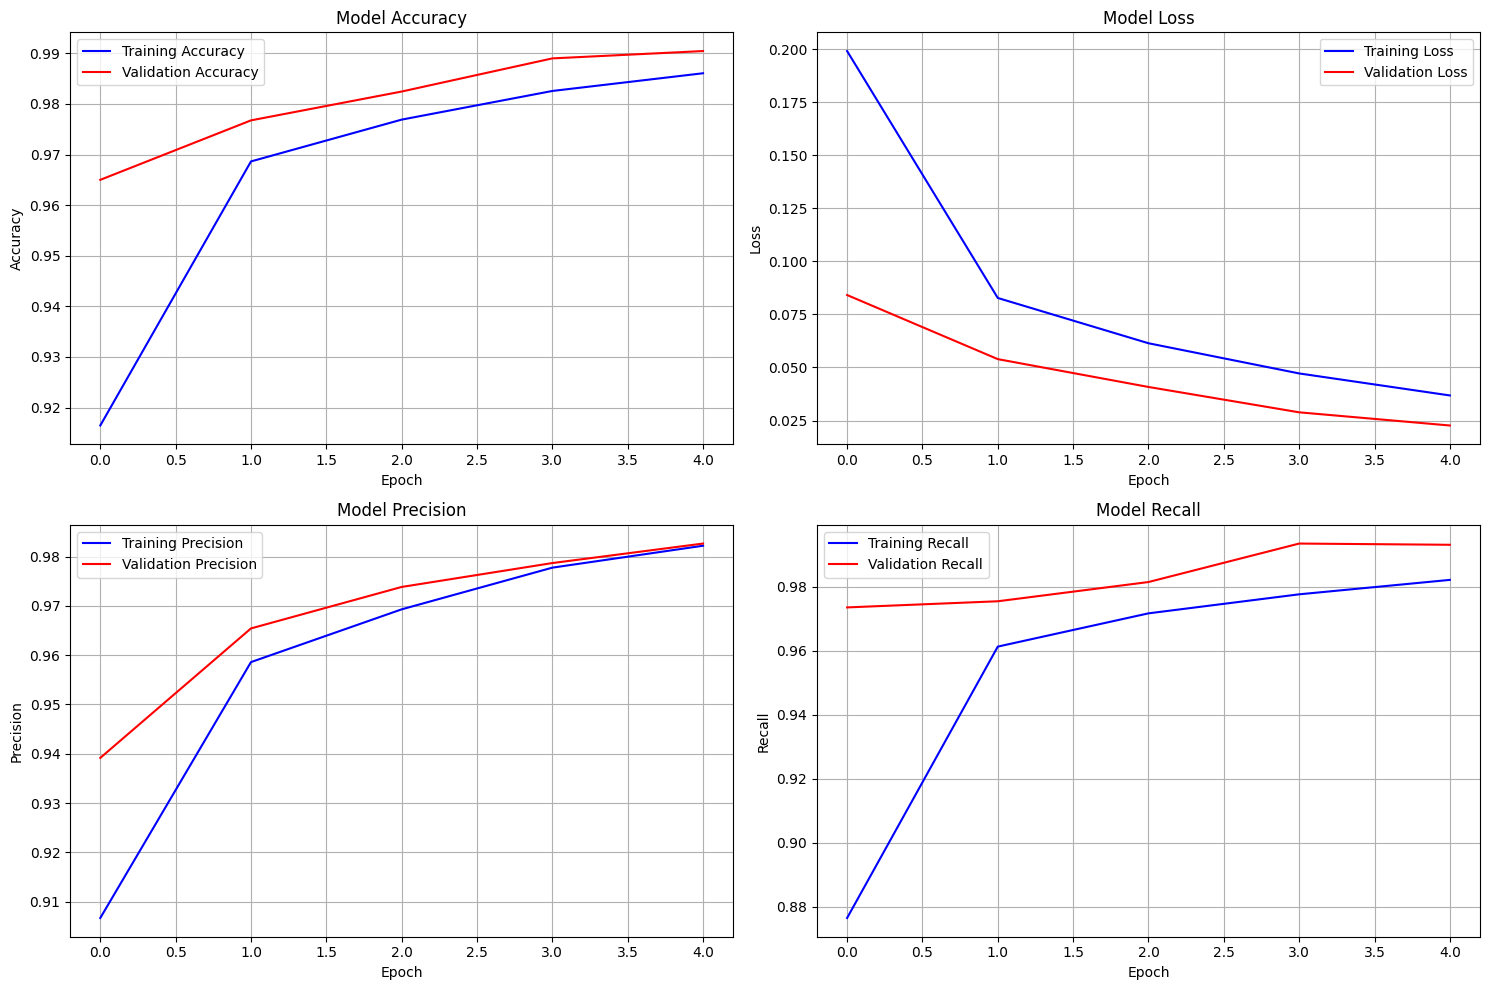

TESTING MODEL EVALUATION
Evaluating model...
Model Evaluation Results:
Accuracy: 0.9905

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12183
           1       0.98      0.99      0.99      7817

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



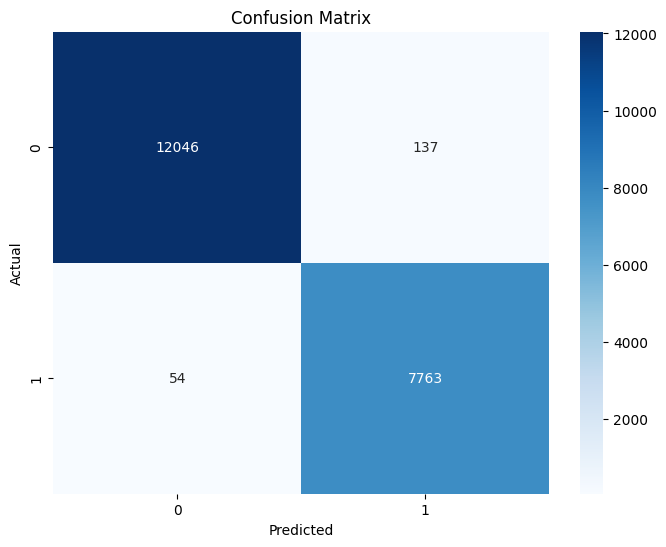

TESTING ANOMALY DETECTION
Detecting anomalies in 100 samples...
Detected 44 anomalies out of 100 samples
Anomaly rate: 0.4400
Plotting anomaly analysis...


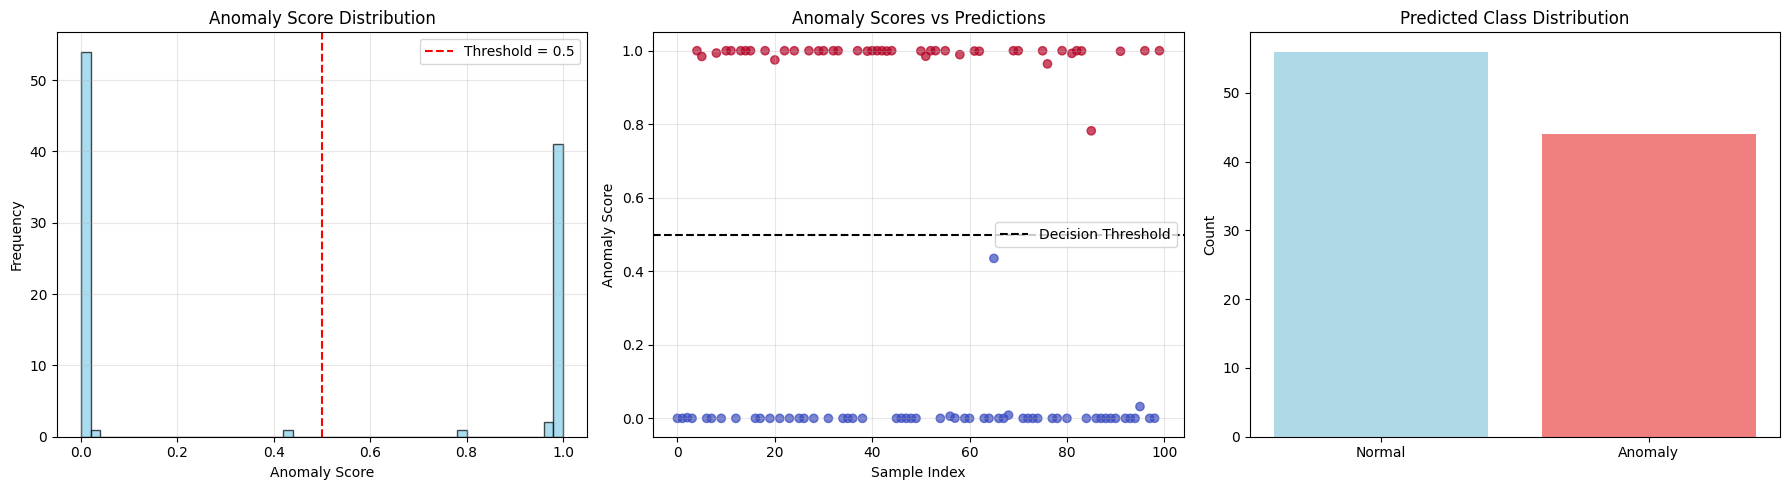

✅ Model, scaler, and encoders saved successfully!
✅ DEBUG PIPELINE COMPLETED SUCCESSFULLY!


In [12]:
# Run the debug pipeline (this will also save the model, scaler, encoders, features)
pipeline_output = run_debug_pipeline(file_path="dataset_sdn.csv", epochs=5)